# Task: Goldfish-to-shark adversarial attack

You are given a set of images that are classified by a model trained on Imagenet as a goldfish (class `GOLDFISH_LABEL=1`).<br>
Your task is to compute a strip of pixels of height 10, which, when pasted into the top 10 rows of *each* of the original images, makes the model classify each image as a shark (class `SHARK_LABEL=2`) with returned probability at least 0.5.

This should run under 2 minutes on CPU.

## Data

Below you can find a piece of code that download a zipfile and displays the images.

In [2]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import zipfile
from io import BytesIO
from PIL import Image
from torch import Tensor
from torchvision.transforms import v2
from typing import cast

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


torch.use_deterministic_algorithms(True)


def get_images(
    url: str = "https://www.mimuw.edu.pl/~cygan/goldfish.zip",
    target_height: int = 100,
    target_width: int = 100,
) -> list[Tensor]:
    """Return five images as tensors of shape (C=3, H=target_height, W=target_width), 0..1 values."""
    request = requests.get(url)
    images = []
    with zipfile.ZipFile(BytesIO(request.content)) as z:
        for filename in z.namelist():
            if not filename.lower().endswith((".jpg", ".jpeg")):
                continue
            with z.open(filename) as f:
                images.append(Image.open(f).convert("RGB"))

    transformations = v2.Compose([
        v2.Resize(size=(target_height, target_width)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),  # scale to 0..1
    ])
    return [cast(Tensor, transformations(img)) for img in images]


def tensor_to_pil(image: Tensor) -> PIL.Image.Image:
    """Convert image tensor of shape (C, H, W), values 0..1, to PIL Image."""
    C, H, W = image.shape
    image = image.detach().permute(1, 2, 0).clone()  # to (H, W, C)
    img = PIL.Image.fromarray((image.numpy() * 255).astype(np.uint8))
    return img


normalize_colors = v2.Normalize(
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD
)

torch.Size([3, 100, 100])


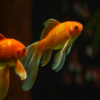

torch.Size([3, 100, 100])


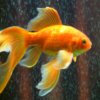

torch.Size([3, 100, 100])


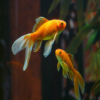

torch.Size([3, 100, 100])


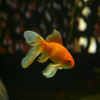

torch.Size([3, 100, 100])


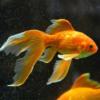

In [3]:
images = get_images()
for img in images:
    print(img.shape)
    display(tensor_to_pil(img))

## Model

We will be using the `mobilenet_v2` model, trained to do classification on the Imagenet dataset.
For this task, the model is a black-box: you do not have to know the details of the model's architecture.
In particular the model's weights should not be changed.

In [4]:
import torch.nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

DEFAULT_DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_model(device: str = DEFAULT_DEVICE) -> torch.nn.Module:
    """Load a pretrained MobileNetV2 model.

    Input: normalized (not 0..1) images of shape (B, C, H, W),
    Output: logits (not probabilities or logprobs) of shape (B, num_classes=1000,).
    """
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    model.to(torch.device(device))
    model.eval()
    model.requires_grad_(False)
    return model

GOLDFISH_LABEL = MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"].index("goldfish")
SHARK_LABEL = MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"].index("great white shark")
GOLDFISH_LABEL, SHARK_LABEL

(1, 2)

In [5]:
model = get_model()
model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Evaluation

Below is a piece of code for:
* pasting the strip and running model inference on a normalized image;
* evaluating how well a strip performs, for this attack task.

In [6]:
STRIP_HEIGHT = 10

def evaluate_strip(model: torch.nn.Module, images: list[Tensor], strip: Tensor) -> None:
    """
    Print goldfish and shark probabilities for each image with the given strip pasted on top.

    Args:
    - model: the classification model.
    - images: list of tensors of shape (3, H, W), values 0..1
    - strip: tensor of shape (3, STRIP_HEIGHT, W), values 0..1.
    """
    C, H, W = images[0].shape
    assert strip.shape == (C, STRIP_HEIGHT, W)
    assert strip.min() >= 0 and strip.max() <= 1, f"Strip should be 0..1, got {strip.min()=}, {strip.max()=}."

    device = next(model.parameters()).device

    for img in images:
        img = img.clone().to(device)
        img[:, :strip.shape[1], :] = strip.to(device)
        img = normalize_colors(img)
        logits = model(img.unsqueeze(0)).squeeze(0)  # Shape (num_classes=1000,)
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        p_goldfish, p_shark = probabilities[[GOLDFISH_LABEL, SHARK_LABEL]]
        # print(f'Probabilities assigned to: goldfish={p_goldfish:.5%}, shark={p_shark:.5%}.')


zero_strip = torch.zeros(3, STRIP_HEIGHT, images[0].shape[2])
evaluate_strip(model, images, zero_strip)

## TO IMPLEMENT

Here you have to implement the function that finds the strip.


iteration 199: p_shark=0.5445088148117065, p_goldfish=0.33979490399360657: 100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


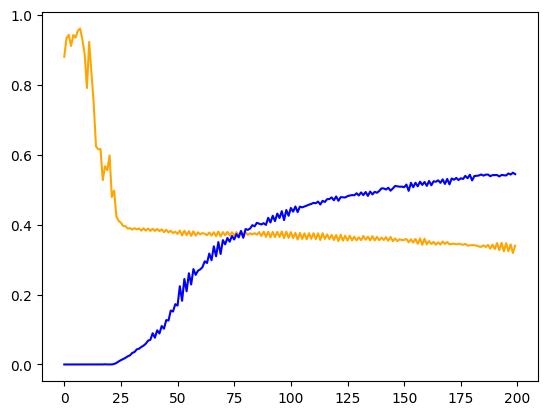

In [15]:
import matplotlib.pyplot as plt
import tqdm

# junk, ignore
def get_img_with_strip(device, img, strip):
      img = img.clone().to(device)
      img[:, :strip.shape[1], :] = strip.to(device)
      img = normalize_colors(img)
      return img

def predict_for_img(model, img):
    logits = model(img.unsqueeze(0)).squeeze(0)
    return logits

def calculate_strip(model: torch.nn.Module, images: list[Tensor], seed: int = 1, quiet: bool = False) -> Tensor:
    device = next(model.parameters()).device
    torch.manual_seed(seed)

    strip_weights = torch.full((3, STRIP_HEIGHT, images[0].shape[2]), 0.5, device=device)
    # strip_weights = torch.rand((3, STRIP_HEIGHT, images[0].shape[2]), device=device)
    # strip_weights = torch.clamp(strip_weights, 0, 1)
    lr = 0.1

    avg_p_goldfish = []
    avg_p_shark = []
    iterations = tqdm.tqdm(range(200))
    for i in iterations:
        grad_strip = torch.zeros_like(strip_weights)

        # For each image, compute gradient w.r.t. input
        for img in images:
            img_with_strip = img.clone().to(device)
            img_with_strip[:, :STRIP_HEIGHT, :] = strip_weights
            img_with_strip = normalize_colors(img_with_strip)
            img_with_strip.requires_grad = True  # Enable grad for INPUT

            logits = model(img_with_strip.unsqueeze(0)).squeeze(0)

            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            if probabilities[SHARK_LABEL] < 1e-6:
              loss = -logits[SHARK_LABEL] * 10 + logits[GOLDFISH_LABEL] # Faster LR in the beginning
            elif probabilities[GOLDFISH_LABEL] > 0.01:
              loss = -logits[SHARK_LABEL] + logits[GOLDFISH_LABEL]
            else:
              loss = -logits[SHARK_LABEL] # Maximize shark

            loss.backward()

            grad_strip += img_with_strip.grad[:, :STRIP_HEIGHT, :]

        grad_strip /= len(images)
        strip_weights -= lr * grad_strip
        strip_weights = torch.clamp(strip_weights, 0, 1)

        # Just for graphs
        p_goldfish = []
        p_shark = []
        for img in images:
          logits = predict_for_img(model, get_img_with_strip(device, img, strip_weights))
          probabilities = torch.nn.functional.softmax(logits, dim=-1)
          p_shark.append(probabilities[SHARK_LABEL])
          p_goldfish.append(probabilities[GOLDFISH_LABEL])
        avg_p_goldfish.append(np.mean(p_goldfish))
        avg_p_shark.append(np.mean(p_shark))
        iterations.set_description(f"iteration {i}: p_shark={avg_p_shark[-1]}, p_goldfish={avg_p_goldfish[-1]}")
        # end

    plt.plot(avg_p_goldfish, color='orange')
    plt.plot(avg_p_shark, color='blue')
    plt.show()
    return strip_weights, avg_p_shark, avg_p_goldfish

strip_weights, p_shark, p_goldfish = calculate_strip(model, images)

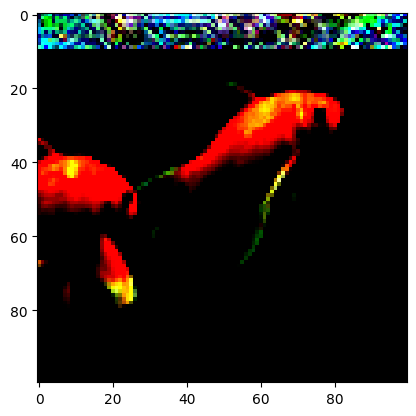

In [76]:
img_with_strip = images[0].clone()
img_with_strip[:, :STRIP_HEIGHT, :] = strip_weights
img_with_strip = normalize_colors(img_with_strip)

img_to_display = img_with_strip.permute(1, 2, 0).cpu().numpy()

plt.imshow(img_to_display)
plt.show()

In [8]:
# junk, ignore
def get_img_with_strip(device, img, strip):
      img = img.clone().to(device)
      img[:, :strip.shape[1], :] = strip.to(device)
      img = normalize_colors(img)
      return img

def predict_for_img(model, img):
    logits = model(img.unsqueeze(0)).squeeze(0)
    return logits

def calculate_loss(device, images, strip_weights):
  losses = []
  for img in images:
    losses.append(predict_for_img(model, get_img_with_strip(device, img, strip_weights))[SHARK_LABEL])
  return sum(losses).item()

def calculate_strip(model: torch.nn.Module, images: list[Tensor], seed: int = 1, quiet: bool = False) -> Tensor:
    device = next(model.parameters()).device
    torch.manual_seed(seed)

    ## TODO
    #strip = torch.normal(0.5, 1, size=(STRIP_HEIGHT, images[0].shape[2]))
    strip_weights = torch.rand(size=(3, STRIP_HEIGHT, images[0].shape[2]))
    lr = 0.01
    step = 0.01
    n = len(images)

    avg_p_goldfish = []
    avg_p_shark = []
    iterations = tqdm.tqdm(range(100))
    for i in iterations:

        grads = torch.zeros(size=strip_weights.shape)

        for color in range(strip_weights.shape[0]):
          for pixel_y in range(strip_weights.shape[1]):
            for pixel_x in range(strip_weights.shape[2]):
                strip_weights[color][pixel_y][pixel_x] += step
                loss_plus = calculate_loss(device, images, strip_weights)

                strip_weights[color][pixel_y][pixel_x] -= 2 * step
                loss_minus = calculate_loss(device, images, strip_weights)

                strip_weights[color][pixel_y][pixel_x] += step

                grads[color][pixel_y][pixel_x] = (loss_plus - loss_minus) / (2 * step)

        strip_weights = strip_weights - lr * grads
        strip_weights = torch.clamp(strip_weights, 0, 1)

        # Just for graphs
        p_goldfish = []
        p_shark = []
        for img in images:
          logits = predict_for_img(model, get_img_with_strip(device, img, strip_weights))
          probabilities = torch.nn.functional.softmax(logits, dim=-1)
          p_shark.append(probabilities[SHARK_LABEL])
          p_goldfish.append(probabilities[GOLDFISH_LABEL])
        avg_p_goldfish.append(np.mean(p_goldfish))
        avg_p_shark.append(np.mean(p_shark))
        # end

        iterations.set_description(f"iteration {i}: p_shark={avg_p_shark[-1]}, p_goldfish={avg_p_goldfish[-1]}")
        evaluate_strip(model, images, strip_weights)

    ## END TODO
    plt.plot(avg_p_goldfish, color='orange')
    plt.plot(avg_p_shark, color='blue')
    plt.show()
    return strip_weights, avg_p_goldfish, avg_p_shark


your_strip, p_goldfish, p_shark = calculate_strip(model, images)

  0%|          | 0/100 [00:09<?, ?it/s]


KeyboardInterrupt: 

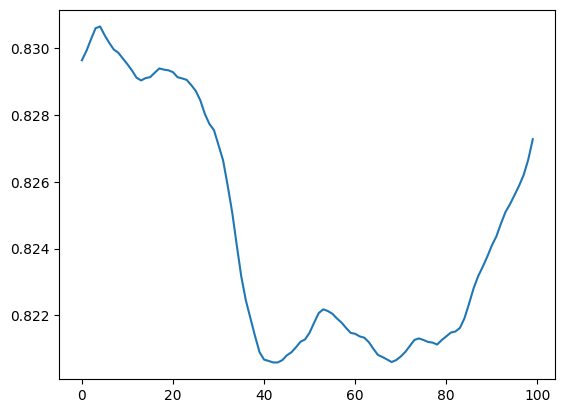

In [50]:
#junk
plt.plot(p_goldfish)
plt.show()

In [ ]:
#junk
        # Backward pass
        # avg = torch.zeros(size=(3, STRIP_HEIGHT, images[0].shape[2]))
        # for img in images:
        #   avg += img[:, :strip_weights.shape[1], :]
        # avg /= len(images)
        # for img in images:
        #   strip_weights += p_goldfish * img[:, :STRIP_HEIGHT, :] - avg[:, :STRIP_HEIGHT, :]

        # for img in images:
        #   delta = img[:, :strip_weights.shape[1], :] - strip_weights
        #   strip_weights = delta * lr
for img in images:
  probabilities = torch.nn.functional.softmax(logits, dim=-1)
  # print(logits[[GOLDFISH_LABEL, SHARK_LABEL]])
  p_shark.append(probabilities[SHARK_LABEL])
  p_goldfish.append(probabilities[GOLDFISH_LABEL])

  if probabilities[SHARK_LABEL] < 1e-8:
    delta = 1/n * (1 - probabilities[GOLDFISH_LABEL])
  else:
    delta = 1/n * probabilities[SHARK_LABEL]
  f = img[:, :strip_weights.shape[1], :] - strip_weights

  # print("delta=", delta)
  # print("f=", f)
  # print("lr=", lr)
  strip_weights += f * delta * lr
  strip_weights = torch.clamp(strip_weights, 0, 1)